Весь процесс получения синтетически летальных пар генов, приведенный ниже можно разделить на три главные части: 

    1) Получение списка генов, которые выключаются в клеточных линиях при наличии мутации в выбранном driver gene

    2) Получение списка генов, у которых статистически значимо увеличивается dependency в клеточных линиях при наличии           мутации в выбранном driver gene

    3) Поиск паралогов из двух этих списков

Импорт библиотек:

In [188]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re
import seaborn as sns

Считывание данных:

In [3]:
dependency = pd.read_csv("C:/Users/57662/Downloads/CRISPR_gene_dependency.csv")
mutations = pd.read_csv("C:/Users/57662/Downloads/CCLE_mutations.csv")
expressions = pd.read_csv("C:/Users/57662/Downloads/CCLE_expression.csv")
annotation = pd.read_csv("C:/Users/57662/Downloads/sample_info.csv")

C:\Users\57662\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,19,22,27,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Искать гены, которые выключаются, и гены, которые становятся очень важными для клеточных линий при определенных нарушениях метаболизма стоит среди клеток из одной ткани, поэтому оставим только клеточные линии, соответствующие раку легких:

In [194]:
Lung_dependency = pd.merge(dependency, annotation[annotation['primary_disease']=='Lung Cancer']['DepMap_ID'], how='inner', on=['DepMap_ID'])
Lung_dependency.head()

,DepMap_ID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
0,ACH-000012,0.093950,0.027503,0.005102,0.003123,0.013275,0.223061,0.004496,0.113944,0.030286,...,0.741977,0.967114,0.018475,0.032189,0.015316,0.017546,0.049393,0.070070,0.048201,0.274323
1,ACH-000015,0.109688,0.038692,0.043423,0.017573,0.022826,0.035089,0.005565,0.167191,0.030688,...,0.262896,0.087707,0.014024,0.009928,0.003954,0.022728,0.027445,0.055408,0.080072,0.102547
2,ACH-000021,0.117287,0.055061,0.037144,0.042694,0.022372,0.116641,0.041570,0.177494,0.049125,...,0.076919,0.563762,0.012524,0.019605,0.011677,0.026136,0.090486,0.315370,0.072186,0.128808
3,ACH-000029,0.042422,0.033073,0.016627,0.011220,0.197299,0.064158,0.055559,0.049476,0.007736,...,0.104324,0.330692,0.008816,0.007381,0.025168,0.019875,0.046866,0.018904,0.057957,0.498727
4,ACH-000030,0.031257,0.275288,0.010621,0.007887,0.077325,0.237925,0.016974,0.250845,0.009714,...,0.031316,0.766198,0.029967,0.012892,0.033140,0.045843,0.107824,0.022202,0.035287,0.236527


Теперь найдем гены, мутации в которых скорее всего приведут к прогрессированию рака, то есть driver genes:

Согласно статье https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04377-0 самый простой способ определения driver genes - найти самые часто мутирующие гены в исследуемом типе рака. 

Сначала выделим только опасные мутации:

In [24]:
mutations = mutations[mutations['Variant_annotation']=='damaging']

Так же оставим клеточные линии, соответствующие раку легких:

In [193]:
Lung_mutations = pd.merge(mutations[mutations['Variant_annotation']=='damaging'], annotation[annotation['primary_disease']=='Lung Cancer']['DepMap_ID'], how='inner', on=['DepMap_ID'])
Lung_mutations.head()

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,Variant_annotation,CGA_WES_AC,HC_AC,RD_AC,RNAseq_AC,SangerWES_AC,WGS_AC
0,IGSF21,84966,37,1,18554419,18554420,+,Frame_Shift_Ins,INS,-,...,False,0.0,NaN,damaging,NaN,NaN,NaN,NaN,NaN,4:18
1,B4GALT2,8704,37,1,44445557,44445557,+,De_novo_Start_OutOfFrame,SNP,C,...,False,0.0,NaN,damaging,NaN,NaN,NaN,NaN,NaN,8:35
2,LDLRAD1,388633,37,1,54474686,54474686,+,Nonsense_Mutation,SNP,C,...,False,0.0,0.000041,damaging,135:46,NaN,NaN,NaN,135:46,26:6
3,FPGT-TNNI3K,100526835,37,1,74819791,74819791,+,Frame_Shift_Del,DEL,T,...,False,0.0,NaN,damaging,49:302,26:89,NaN,NaN,40:8,9:33
4,FNBP1L,54874,37,1,94009764,94009764,+,Nonsense_Mutation,SNP,C,...,False,0.0,NaN,damaging,34:237,NaN,NaN,NaN,35:249,5:30


Теперь можем выделить самые часто мутирующие гены:

In [26]:
Lung_mutations.groupby(['Hugo_Symbol']).aggregate({'Hugo_Symbol':'count'})['Hugo_Symbol'].sort_values(ascending = False)

Hugo_Symbol
TP53     80
TTN      71
RB1      68
RYR2     43
CSMD3    35
         ..
DSCR8     1
PAGE3     1
PAGE2     1
PAGE1     1
A1CF      1
Name: Hugo_Symbol, Length: 9977, dtype: int64

Видим, что самый главный driver gene - TP53.

Я решил обратить внимание на ген RB1, который является ключевым регулятором G1/S перехода клеточного цикла.          
Отбираем мутации, происходящие в этом гене:

In [44]:
Lung_mutations_RB1 = Lung_mutations[Lung_mutations['Hugo_Symbol']=='RB1']
Lung_mutations_RB1

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,Variant_annotation,CGA_WES_AC,HC_AC,RD_AC,RNAseq_AC,SangerWES_AC,WGS_AC
855,RB1,5925,37,13,48878162,48878162,+,Frame_Shift_Del,DEL,C,...,True,18.0,NaN,damaging,NaN,NaN,NaN,23:0,NaN,NaN
952,RB1,5925,37,13,48881523,48881523,+,Nonsense_Mutation,SNP,C,...,True,20.0,NaN,damaging,111:0,388:0,NaN,78:0,177:0,17:0
1411,RB1,5925,37,13,48916734,48916734,+,Splice_Site,SNP,G,...,True,19.0,NaN,damaging,165:0,30:0,NaN,NaN,171:0,6:0
1630,RB1,5925,37,13,49030485,49030485,+,Splice_Site,SNP,G,...,True,30.0,NaN,damaging,139:0,43:0,NaN,5:1,73:0,NaN
1940,RB1,5925,37,13,48941628,48941628,+,Splice_Site,SNP,A,...,True,25.0,NaN,damaging,150:0,137:0,NaN,NaN,151:0,20:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21494,RB1,5925,37,13,48941657,48941658,+,Frame_Shift_Ins,INS,-,...,True,23.0,NaN,damaging,179:1,NaN,NaN,NaN,107:72,NaN
21577,RB1,5925,37,13,48955465,48955465,+,Frame_Shift_Del,DEL,T,...,True,24.0,NaN,damaging,51:1,NaN,NaN,NaN,33:18,NaN
21675,RB1,5925,37,13,49033891,49033903,+,Frame_Shift_Del,DEL,AGAACATATCATC,...,True,29.0,NaN,damaging,24:0,NaN,NaN,NaN,21:0,NaN
21744,RB1,5925,37,13,48916804,48916804,+,Nonsense_Mutation,SNP,G,...,True,21.0,NaN,damaging,173:0,NaN,NaN,NaN,185:0,NaN


И создаем серию клеточных линий с мутированным RB1: 

In [45]:
RB1_Cell_lines = Lung_mutations[(Lung_mutations['Hugo_Symbol'] == "RB1") ]['DepMap_ID']
RB1_Cell_lines

855      ACH-000179
952      ACH-000187
1411     ACH-000298
1630     ACH-000319
1940     ACH-000355
            ...    
21494    ACH-002176
21577    ACH-002177
21675    ACH-002193
21744    ACH-002196
21845    ACH-002286
Name: DepMap_ID, Length: 68, dtype: object

Для поиска плохо экспрессируемых генов в клеточных линиях с мутированным RB1, по сравнению с клеточными линиями с диким типом RB1,
сначала уберем из экспрессий мешающийся столбец 'Unnamed: 0', а затем посчитаем Z-score для всех экспрессий:

In [35]:
all_expr = expressions.set_index('Unnamed: 0', drop=True).rename_axis(None)
Lung_expr = all_expr.loc[all_expr.index.isin(Lung_dependency['DepMap_ID'])]

Lung_expr_zscored = Lung_expr.apply(lambda x: stats.zscore(x) if not (x==0).all() else 0)
Lung_expr_zscored.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,ARHGAP11B (89839),AC004593.2 (1124),AC090517.4 (54816),AL160269.1 (11046),ABCF2-H2BE1 (114483834),POLR2J3 (548644),H2BE1 (114483833),AL445238.1 (647264),GET1-SH3BGR (106865373),AC113348.1 (102724657)
ACH-000528,0.747565,-0.183695,0.973578,1.169500,1.205071,-0.252094,-0.658480,0.817195,-0.934467,0.021656,...,-0.426760,0.055070,-0.506056,-0.732948,-0.367226,-0.616350,-0.354814,-0.330915,-0.596346,-0.229284
ACH-000769,0.913330,-0.183695,-0.657023,0.318333,0.395976,-0.298959,-1.004652,0.129393,0.327299,-0.579213,...,-0.845709,3.595242,-0.506056,-0.524032,-1.353609,-0.238956,-0.354814,-0.330915,-1.468803,-0.229284
ACH-000800,-0.712111,-0.183695,0.117580,0.500984,0.648644,-0.252094,-0.860237,-0.399227,-0.418832,2.132498,...,-0.284459,-0.876718,2.367938,-0.732948,-0.235855,-0.647023,-0.354814,0.594632,0.940155,0.468663
ACH-000700,-2.924528,-0.183695,1.402197,-0.663886,0.488303,-0.252094,-1.030856,0.246222,0.425972,0.564879,...,0.379325,0.231226,-1.349139,-0.524032,0.085571,0.214195,3.891882,-0.330915,1.844285,-0.229284
ACH-001547,-0.599546,0.281640,-0.055472,-1.018068,-0.849913,2.002225,0.145865,-0.370029,-0.198991,-1.272346,...,-1.168482,-0.779440,-0.506056,-0.592986,-0.564471,-2.215269,-0.354814,-0.330915,0.205174,-0.229284


Отберем z-score экспрессий и сами экспрессии в клеточных линиях с мутированнм RB1:

In [46]:
Lung_expr_zscored_RB1 = Lung_expr_zscored[Lung_expr_zscored.index.isin(RB1_Cell_lines)]
Lung_expr_RB1 = Lung_expr[Lung_expr.index.isin(RB1_Cell_lines)]


Выберем 1500 генов с самыми низкими z-scores и получим кандидатов "выключающихся" генов (названы как А2):

In [291]:
A2_candidates = Lung_expr_zscored_RB1.mean(axis=0).sort_values().head(1500)
A2_candidates

H2AJ (55766)        -1.464921
TMBIM1 (64114)      -1.399493
YAP1 (10413)        -1.392129
RHBDF1 (64285)      -1.354770
CCND1 (595)         -1.336677
                       ...   
C17orf67 (339210)   -0.437813
TMEM40 (55287)      -0.437811
UBE2V1 (7335)       -0.437510
SGCE (8910)         -0.437244
CEMIP2 (23670)      -0.437144
Length: 1500, dtype: float64

Вот так экспрессируются эти гены в клеточных линиях с диким типом RB1: 

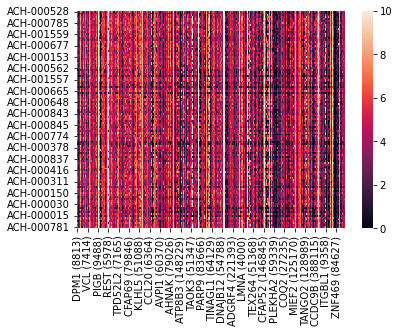

In [361]:
import seaborn as sns
RB1_wt = Lung_expr.loc[~Lung_expr.index.isin(RB1_Cell_lines),Lung_expr.columns.isin(A2_candidates.index)]
ax = sns.heatmap(RB1_wt, vmin=0, vmax=10)


А вот так в клеточных линиях с мутированным RB1:

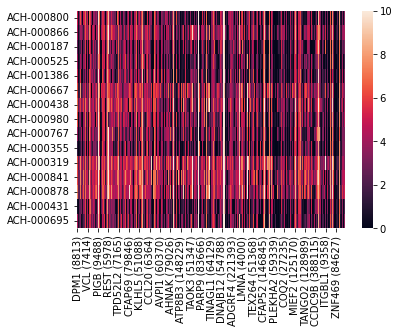

In [362]:
RB1_mutated = Lung_expr_RB1.loc[:,Lung_expr_RB1.columns.isin(A2_candidates.index)]
ax = sns.heatmap(RB1_mutated, vmin=0, vmax=10)

Пока что нельзя сказать, что гены выключились, поэтому наложим дополнительное условие на значение конечной экспрессии (условие взято из статьи https://www.sciencedirect.com/science/article/pii/S240547122100329X)

In [364]:
RB1_mutated = RB1_mutated.loc[:,(np.log(RB1_mutated.mean() + 1) < 1)]
RB1_wt = RB1_wt.loc[:,RB1_wt.columns.isin(RB1_mutated_upgrade.columns)]

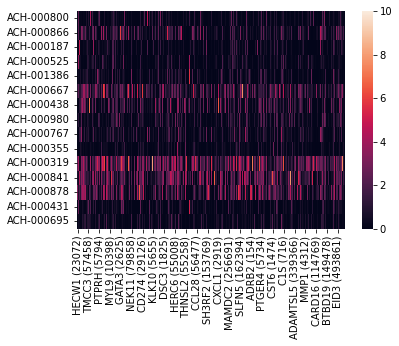

In [365]:
ax = sns.heatmap(RB1_mutated, vmin=0, vmax=10)

Стало лучше, но нужно проверить, что изменение экспрессии этих генов в клеточных линиях с мутированным RB1 не случайно, для этого воспользуемся t-критерием Стьюдента.

In [331]:
A2_candidates_upgrade = A2_candidates_upgrade[scipy.stats.ttest_ind(RB1_wt_upgrade,RB1_mutated_upgrade).pvalue < 0.05]

Так же уберем id генов:

In [332]:
A2_candidates_filtred = A2_candidates_upgrade.index.str.replace(r"\(.*\)","").str.replace(' ','').values.tolist()
A2_candidates_filtred

C:\Users\57662\AppData\Local\Temp/ipykernel_19576/657926759.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  A2_candidates_filtred = A2_candidates_upgrade2.index.str.replace(r"\(.*\)","").str.replace(' ','').values.tolist()


['HFE',
 'ICAM3',
 'GPR39',
 'APOBEC3C',
 'SLC16A5',
 'TEC',
 'CGAS',
 'IKBKE',
 'CPEB2',
 'SAMD4A',
 'LRRC8E',
 'CCDC102A',
 'INPP4B',
 'TRIM34',
 'SPEF2',
 'TRIM6',
 'SH3RF2',
 'LATS2',
 'ADAMTSL5',
 'BIRC3',
 'PPP1R3B',
 'AKAP7',
 'RBM43',
 'ALPK1',
 'ACAP1',
 'ORAI3',
 'P3H2',
 'VSIR',
 'CTF1',
 'LPAR1',
 'STBD1',
 'THSD4',
 'C15orf48',
 'PSORS1C1',
 'MAP3K8',
 'HRH1',
 'SYDE1',
 'ZNF888',
 'PTPRH',
 'RIN3',
 'FANK1',
 'STYK1',
 'RHBDL2',
 'TMEM144',
 'SLFN12',
 'SLFN5',
 'PERM1',
 'TLR3',
 'PCED1B',
 'EID3',
 'PLBD1',
 'GATA3',
 'IL1R1',
 'MYEOV',
 'APLF',
 'TGFB2',
 'ATF7IP2',
 'ARSD',
 'NUDT13',
 'HKDC1',
 'PPP2R3A',
 'PTGER4',
 'DDX60',
 'CGB7',
 'CXCL2',
 'USP43',
 'VEGFC',
 'GALNT4',
 'UPK3B',
 'AOX1',
 'CPA4',
 'CREBRF',
 'TNFAIP3',
 'HERC6',
 'NBPF10',
 'MSRB3',
 'NTF4',
 'TMEM45A',
 'APOL6',
 'PEX11G',
 'MR1',
 'STX11',
 'EDN1',
 'LPCAT2',
 'SLC16A13',
 'DYSF',
 'ANXA8',
 'ARL14',
 'IL15',
 'RILPL2',
 'TACSTD2',
 'PID1',
 'RAB27B',
 'CDRT1',
 'C4orf36',
 'TCAF2',
 'ZNF860'

    Мы получили список генов, которые выключаются в клеточных линиях при наличии мутации в RB1.

    Теперь найдем список генов, у которых увеличивается dependency в клеточных линиях при наличии мутации в выбранном       driver gene. 
    
    Для этого проделаем такой же анализ с dependency:

In [334]:
all_dep = dependency.set_index('DepMap_ID', drop=True).rename_axis(None)
Lung_dep = all_dep.loc[all_dep.index.isin(Lung_dependency['DepMap_ID'])]

Lung_dep_zscored = Lung_dep.apply(lambda x: stats.zscore(x) if not (x==0).all() else 0)
Lung_dep_zscored.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
ACH-000012,1.076623,-0.715297,-0.834680,-0.833758,-0.928694,2.336761,-1.152035,-0.686259,-0.223394,-0.458856,...,3.569536,1.300810,NaN,NaN,-0.469202,-0.764173,-0.545677,0.600459,-0.449623,-0.052272
ACH-000015,1.437214,-0.498174,0.404391,-0.213257,-0.800206,-0.669745,-1.110661,-0.340763,-0.217369,-0.351640,...,0.610208,-1.649028,NaN,NaN,-0.683823,-0.622525,-0.830168,0.279435,-0.032940,-0.962416
ACH-000021,1.611333,-0.180533,0.201351,0.865487,-0.806311,0.634641,0.282100,-0.273914,0.059505,-0.006732,...,-0.538591,-0.052172,NaN,NaN,-0.537945,-0.529361,-0.013015,5.971090,-0.136050,-0.823273
ACH-000029,-0.104034,-0.607220,-0.462013,-0.486082,1.546981,-0.204806,0.823217,-1.104565,-0.562035,0.100008,...,-0.369306,-0.833971,NaN,NaN,-0.283107,-0.700507,-0.578432,-0.519788,-0.322078,1.136716
ACH-000030,-0.359856,4.092995,-0.656213,-0.629193,-0.067030,2.574496,-0.669362,0.202033,-0.532329,-0.263576,...,-0.820282,0.626866,NaN,NaN,-0.132541,0.009374,0.211724,-0.447591,-0.618464,-0.252533


In [335]:
Lung_dep_zscored_RB1 = Lung_dep_zscored[Lung_dep_zscored.index.isin(RB1_Cell_lines)]
Lung_dep_RB1 = Lung_dep[Lung_dep.index.isin(RB1_Cell_lines)]

In [336]:
df1 = Lung_dep_zscored_RB1.mean(axis=0)[Lung_dep_zscored_RB1.mean(axis=0)>0.7]
df2 = Lung_dep_RB1.mean(axis=0)[Lung_dep_RB1.mean(axis=0)>0.4]
A1_candidates = df2.loc[df2.index.intersection(df1.index)].sort_values(ascending = False)
A1_candidates.index

Index(['E2F3 (1871)', 'TYRO3 (7301)', 'UBE2Q1 (55585)', 'SLC16A1 (6566)',
       'PCM1 (5108)'],
      dtype='object')

Как оказалось, генов, у которых достаточно сильно выросла dependency немного, поэтому пришлось экспериментировать с минимальным средним значением dependency и его z-score. Более-менее оптимальные параметры оказались 0.4 и 0.7 соответственно.

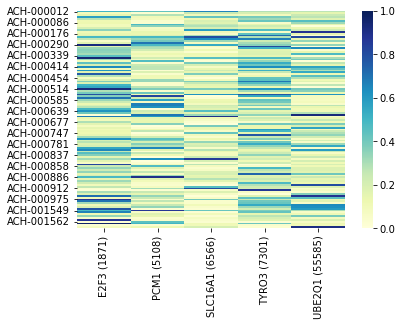

In [339]:
RB1_wt_dep = Lung_dep.loc[~Lung_dep.index.isin(RB1_Cell_lines),Lung_dep.columns.isin(A1_candidates.index)]
ax = sns.heatmap(RB1_wt_dep, vmin=0, vmax=1, cmap="YlGnBu")

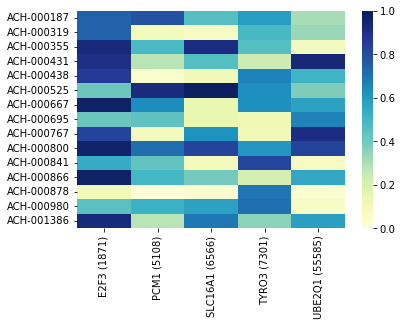

In [340]:
RB1_mutated_dep = Lung_dep_RB1.loc[:,Lung_dep_RB1.columns.isin(A1_candidates.index)]
ax = sns.heatmap(RB1_mutated_dep, vmin=0, vmax=1,cmap="YlGnBu")


Несмотря на кажущуюся слабость изменения, оно оказалось статистически значимым для отфильтрованных генов:

In [342]:
scipy.stats.ttest_ind(RB1_wt_dep,RB1_mutated_dep).pvalue < 0.05

array([ True,  True,  True,  True,  True])

Таким образом мы получили список потенциальных синтетически летальных пар к генам А2 (обозначены как А1)

In [344]:
A1_candidates_filtred = A1_candidates.index.str.replace(r"\(.*\)","").str.replace(' ','').values.tolist()
A1_candidates_filtred

C:\Users\57662\AppData\Local\Temp/ipykernel_19576/4074409660.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  A1_candidates_filtred = A1_candidates.index.str.replace(r"\(.*\)","").str.replace(' ','').values.tolist()


['E2F3', 'TYRO3', 'UBE2Q1', 'SLC16A1', 'PCM1']

Хотя паралоги и расходятся с функциональной точки зрения, даже после длительного времени они могут сохранить общие функции. Из-за этого паралоги иногда могут компенсировать потерю одного гена из пары другим.

Среди синтетически летальных пар 25 - 35 % являются паралогами, при этом 60 % человеческих генов имеют идентифицируемых паралогов (https://www.sciencedirect.com/science/article/pii/S240547122100329X), таким образом есть смысл искать синтетически-летальные пары среди паралогов.

Найдем паралогов к каждому гену из A1_candidates_filtred, для этого можно запустить такой скрипт в R-studio:

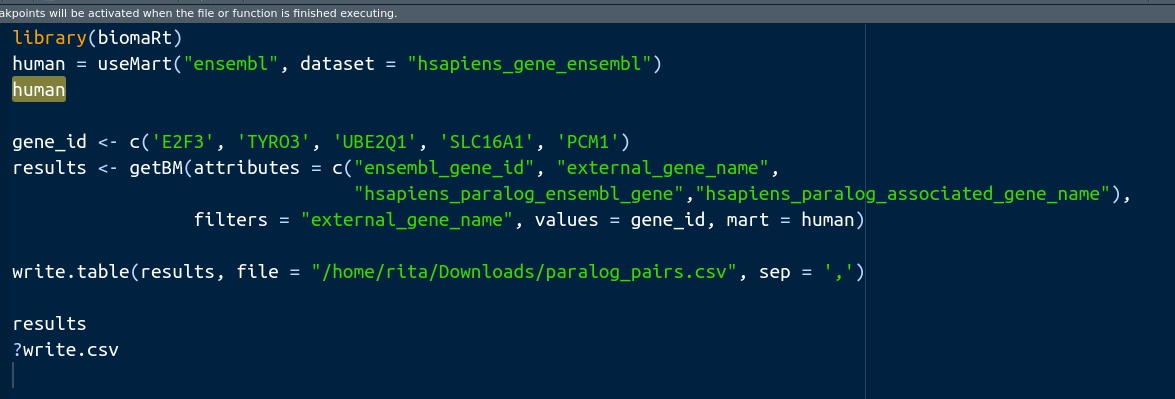

Получаем такой датафрейм:

In [346]:
paralogs = pd.read_csv("C:/Users/57662/Downloads/paralog_pairs.csv")
paralogs

,ensembl_gene_id,external_gene_name,hsapiens_paralog_ensembl_gene,hsapiens_paralog_associated_gene_name
1,ENSG00000281917,SLC16A1,NaN,NaN
2,ENSG00000092445,TYRO3,ENSG00000065361,ERBB3
3,ENSG00000092445,TYRO3,ENSG00000141736,ERBB2
4,ENSG00000092445,TYRO3,ENSG00000153208,MERTK
5,ENSG00000092445,TYRO3,ENSG00000163785,RYK
...,...,...,...,...
84,ENSG00000160714,UBE2Q1,ENSG00000072401,UBE2D1
85,ENSG00000160714,UBE2Q1,ENSG00000170035,UBE2E3
86,ENSG00000160714,UBE2Q1,ENSG00000185651,UBE2L3
87,ENSG00000160714,UBE2Q1,ENSG00000236444,UBE2L5


Ищем среди среди паралогов А1 гены из А2:

In [347]:
for gene in paralogs['hsapiens_paralog_associated_gene_name'].dropna():
    if (gene in A2_candidates_filtred):
        print (gene)

SLC16A13
SLC16A5


Им соответствует SLC16A1:

In [348]:
paralogs[(paralogs['hsapiens_paralog_associated_gene_name'] == 'SLC16A13') | (paralogs['hsapiens_paralog_associated_gene_name'] == 'SLC16A5')]

,ensembl_gene_id,external_gene_name,hsapiens_paralog_ensembl_gene,hsapiens_paralog_associated_gene_name
71,ENSG00000155380,SLC16A1,ENSG00000174327,SLC16A13
72,ENSG00000155380,SLC16A1,ENSG00000170190,SLC16A5


В итоге мы получили, что при отключении SLC16A5 и SLC16A13, у клетки возрастает потребность в экспрессии их паралога гена SLC16A1. Можем предположить, что SLC16A5 и SLC16A1 или SLC16A13 и SLC16A1 - синтетически лктальные пары, хотя вполне может быть и так, что SLC16A1 не станет критически важным для клеточных линий только при отключении одного из генов SLC16A5 и SLC16A13.

Визуализирем возрастание нужды клетки в правильной работе гена SLC16A1 с помощью боксплота:

C:\Users\57662\AppData\Local\Temp/ipykernel_19576/1202724180.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  y.columns = y.columns.str.replace(r"\(.*\)","").str.replace(' ','')


Text(0, 0.5, 'SLC16A1 dependency')

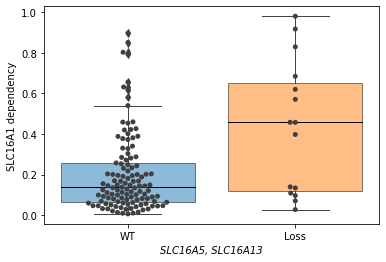

In [438]:
y =Lung_dependency.iloc[:, 1:]
y.columns = y.columns.str.replace(r"\(.*\)","").str.replace(' ','')

X = Lung_dependency['DepMap_ID'].isin(RB1_Cell_lines)
X = X.apply(lambda x: ('Loss' if x else 'WT'))

df=pd.DataFrame()
df['A1_dependency'] = y['SLC16A1']
df['A2_loss'] = X

ax = sns.boxplot(y='A1_dependency', x='A2_loss', data=df,  linewidth=0.98, saturation=1, boxprops=dict(alpha=0.5, edgecolor='black'), 
                medianprops=dict(linewidth=1, color='black'))
ax = sns.swarmplot(y='A1_dependency', x='A2_loss', data=df, color=".25")
ax.set_xlabel('SLC16A5, SLC16A13', fontstyle='italic');
ax.set_ylabel('SLC16A1 dependency')

__Вывод: В итоге мы получили, что при мутации гена RB1 в клеточных линиях рака легких метаболизм нарушается таким образом, что прекращается экспрессия генов из A2_candidates_filtred. Далее мы предположили, что в результате этого отключения генов найдутся гены, нужда в которых у клеток сильно возрастет. Это гены A1_candidates_filtred. В итоге у нас есть два набора генов, и чтобы получить синтетически летальные пары, можно, например, найти такие паралоги, один из которых находится в первом наборе, а второй - во втором наборе. После отбора паралогов мы получили, что кандидаты на синтетически - летальные пары - SLC16A5 и SLC16A1 и 
SLC16A13 и SLC16A1 (хотя вполне может быть и так, что SLC16A1 не станет критически важным для клеточных линий только при отключении одного из генов SLC16A5 и SLC16A13)__